In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import rospy, tf

In [2]:
def show(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB));

In [3]:
shuttle = cv2.imread('img/shuttle.png')

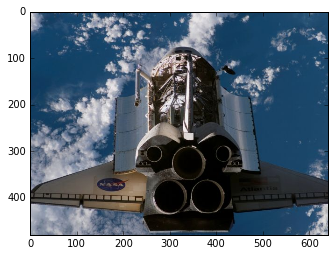

In [4]:
show(shuttle)

# Play around with remapping images

In [5]:
def corners(img):
    h, w = np.shape(img)[:2]
    return np.array([(0,0), (w, 0), (w, h), (0, h)], "float32")

## Define the transform

In [6]:
input_points = corners(shuttle)
output_points= np.array([(20,15), (120,0), (100,100), (0,120)], "float32")
# output_points = corners(canvas)

matrix = cv2.getPerspectiveTransform(input_points, output_points)

In [7]:
matrix

array([[  1.66015625e-01,  -4.16666667e-02,   2.00000000e+01],
       [ -2.34375000e-02,   2.21354167e-01,   1.50000000e+01],
       [  8.13802083e-05,   2.17013889e-05,   1.00000000e+00]])

## Use the transform

In [8]:
canvas = np.zeros((200, 200, 3), np.uint8)
# show(canvas)

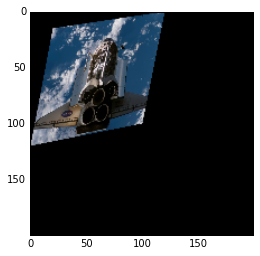

In [9]:
warped = cv2.warpPerspective(shuttle, matrix, np.shape(canvas)[:2], borderMode=cv2.BORDER_CONSTANT)
show(warped)

# Pipelining through ROS

In [10]:
rospy.init_node('ipython', anonymous=True)
listener = tf.TransformListener()
publisher = tf.TransformBroadcaster()

In [11]:
publisher.sendTransform([0, 0, .5], [0,0,0,1], rospy.Time(0), 'camera', 'base_link')
print listener.allFramesAsString()

In [17]:
listener.lookupTransform('camera', 'base_link', rospy.Time(0))

((-0.14197172323662935, -2.8882771246803636e-16, -0.17419531206099037),
 (-1.012388249517675e-15,
  -0.08715574274766069,
  -1.1966658375302763e-16,
  0.9961946980917453))

## Playing with image_geometry

In [18]:
from image_geometry import PinholeCameraModel
from sensor_msgs.msg import CameraInfo
from geometry_msgs.msg import Vector3, Vector3Stamped
from std_msgs.msg import Header

In [19]:
camera = PinholeCameraModel()
def infoCB(msg):
    global camera
    camera.fromCameraInfo(msg)

infosub = rospy.Subscriber('/alpha/camera_info', CameraInfo, infoCB)

In [20]:
camera.fullResolution()

(640, 480)

In [21]:
vec=camera.projectPixelTo3dRay((0,0))
print vec
print listener.transformVector3('base_link', 
                          Vector3Stamped(header=Header(frame_id=camera.tf_frame), vector=Vector3(*vec)))

(-0.4622995678577474, -0.33161103410105314, 0.8223826552286777)
header: 
  seq: 0
  stamp: 
    secs: 0
    nsecs:         0
  frame_id: base_link
vector: 
  x: -0.312470949215
  y: -0.331611034101
  z: 0.890166292307


In [30]:
camera.project3dToPixel((0,0,1))

(331.97481150978268, 238.36543612997411)

# Real attempt #1

In [31]:
from image_geometry import PinholeCameraModel
from sensor_msgs.msg import CameraInfo
from geometry_msgs.msg import Vector3, Vector3Stamped, Point, PointStamped
from std_msgs.msg import Header

In [23]:
camera = PinholeCameraModel()
def infoCB(msg):
    global camera
    camera.fromCameraInfo(msg)

infosub = rospy.Subscriber('/alpha/camera_info', CameraInfo, infoCB)

In [120]:
def projectFloorPoint(pt, camera=camera):
    point3d = PointStamped(
        point=Point(pt[0], pt[1], 0), 
        header=Header(frame_id='base_link'))
    
    camPoint = listener.transformPoint('camera', point3d).point
    return camera.project3dToPixel((camPoint.y, camPoint.z, camPoint.x))
    
    
def projectCameraPoint(pixel, camera=camera, frame='base_link'):
    # Find origin of camera in robot frame
    camPoint = listener.lookupTransform(
        frame, 'camera', rospy.Time(0))[0]
    
    # Find vector of ray in robot frame
    camVector = list(camera.projectPixelTo3dRay(pixel))
    camVector[0], camVector[1], camVector[2] = camVector[2], camVector[0], camVector[1]
    robotVector = listener.transformVector3(frame, Vector3Stamped(
        vector=Vector3(*camVector), 
        header=Header(frame_id='camera'))).vector
    
    robotVector = (robotVector.x, robotVector.y, robotVector.z)
    
    
    vectorMults = -camPoint[2] / robotVector[2]
    floorPoint = tuple([camPoint[i] + vectorMults*robotVector[i] for i in range(3)])
    
    return floorPoint
    

In [121]:
print projectCameraPoint((640,300), frame='base_link')
print projectFloorPoint((10,0))

(2.2459869990853401, 1.0796392983830909, 0.0)
(331.97481150978263, 333.51436406168619)


## Define the points

In [152]:
def corners(img):
    h, w = np.shape(img)[:2]
    return np.array([(0,0), (w, 0), (w, h), (0, h)], "float32")

In [211]:
# Define the range in the camera feed to use in percent of full image field
xRange = (0.0, 1.0)
yRange = (0.2, 0.4)

# Define the region of floor to project
depthRange = (1.0, 2.0)
crossrange = 0.5

In [212]:
w, h = camera.fullResolution()
campoints = [
    (xRange[0]*w, yRange[0]*h), 
    (xRange[1]*w, yRange[0]*h), 
    (xRange[0]*w, yRange[1]*h), 
    (xRange[1]*w, yRange[1]*h)]

floorPoints = [projectCameraPoint(p)[:2] for p in campoints]
print floorPoints

[(0.50724287128722445, -0.20100392302274719), (0.50724287128722623, 0.18650291868463303), (0.738690675927962, -0.32913488007852792), (0.738690675927967, 0.30539013792589259)]


## Define the transform

In [213]:
floor_resolution = 100  # pixels per meter
input_points = np.array(campoints, "float32")
output_points= np.array(floorPoints, "float32")*floor_resolution + 100
# output_points = corners(canvas)

croppedCamFeed = shuttle[int(xRange[0]*w) : int(xRange[1]*w), int(yRange[0]*h) : int(yRange[1]*h)]

matrix = cv2.getPerspectiveTransform(corners(croppedCamFeed), output_points)

In [214]:
matrix

array([[  1.06581410e-14,  -5.35222489e-01,   1.50724289e+02],
       [  4.03652986e-01,  -3.32542261e-01,   7.98996048e+01],
       [  4.16333634e-17,  -3.35563311e-03,   1.00000000e+00]])

## Use the transform

In [215]:
canvas = np.zeros((300, 300, 3), np.uint8)
# show(canvas)

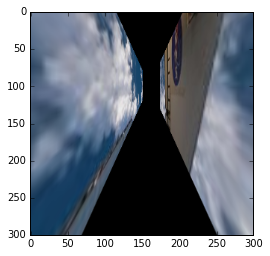

In [216]:
warped = cv2.warpPerspective(croppedCamFeed, 
                             matrix, 
                             np.shape(canvas)[:2], 
                             borderMode=cv2.BORDER_CONSTANT)
show(warped)